In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.126:42763 --name dummy-name --nthreads 36 --memory-limit 93.13GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.126:42763,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load in data

In [65]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
#CM4Xp125_budgets_sigma2_2020-2024
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_ssp585_tracers_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
# ds = ds.compute()
ds["Z"] = approximate_z_on_boundaries(ds, dim = "sigma2") #compute is required to carry out the remapping operations

ds["density"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
ds["density"] = ds["density"].where(ds["density"] > 0)
ds["density"].attrs["cell_methods"] = ds["thetao"].attrs["cell_methods"]

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

In [66]:
# z_i = np.arange(-6500, 200 + 0.1, 100)
z_i_1 = np.arange(-6320, -5000 + 0.1, 20)
z_i_2 = np.arange(z_i_1[-1], 300 + 0.1, 100)
z_i = np.unique(np.concatenate([z_i_1, z_i_2]))

z_l = ((z_i[1:] - z_i[0:-1]) / 2) + z_i[0:-1]
ds = ds.assign_coords({"Z_l": z_l, "Z_i":z_i})
ds = ds.chunk({"sigma2_l":-1, "sigma2_i":-1, "time":1})

In [67]:
ds_remap = remap_vertical_coord_custom("Z", ds, grid, ds["Z"])

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` shoul

In [68]:
ds_remap.thetao.isel(time = 0, yh = 100, xh = 100).compute()

<xarray.DataArray 'thetao' (Z_l: 119)> Size: 952B
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.88271542,  0.90342581,  0.96739435,  0.96739435,  0.96739435,
        0.96739435,  0.96739435,  0.96739435,  1.01483752,  1.2005488 ,
        1.2005488 ,  1.2005488 ,  1.2005488 ,  1.2005488 ,  1.41297609,
        1.49062732,  1.49062732,  1.49062732,  1.49062732,  1.63196528,
        1.71434736,  1.71434736,  1.71434736,  1.71434736,  1.9958455 ,
        2.00460349,  2.00460349,  2.282934  ,  2.37066091,  2.55348598,
        2.70916922,  2.97145774,  3.28589849,  3.63636417,  4.00807814,
        4.4050823 ,  4.82119524,  5.228105  ,  5.64727004,  6.14487804,
        6.82139422,  8.10343817, 10.78712641, 16.75944103, 22.49711476,
       28.05432397, 28.59017202,         nan,         nan])
Coordinates:
    areacello  float32 4B 2.234e+10
    deptho     float32 4B 4.57e+03
    geolat     float64 8B -10.99
    geolon     float64 8B -149.2
    lat        float64 8B -10.99
    lon        float64 8B -149.2
    time       object 8B 2020-01-16 12:00:00
    wet        float32 4B 1.0
    xh         int64 8B 100
    yh         int64 8B 100
  * Z_l        (Z_l) float64 952B -6.31e+03 -6.29e+03 -6.27e+03 ... 150.0 250.0
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean Z_l:mean yh:mean xh:mean time:mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [69]:
ds_remap.density.isel(time = 0, yh = 100, xh = 100).compute()

<xarray.DataArray 'density' (Z_l: 119)> Size: 952B
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       36.974     , 36.9660513 , 36.9415    , 36.9415    , 36.9415    ,
       36.9415    , 36.9415    , 36.9415    , 36.93386935, 36.904     ,
       36.904     , 36.904     , 36.904     , 36.904     , 36.87269376,
       36.86125   , 36.86125   , 36.86125   , 36.86125   , 36.83013569,
       36.812     , 36.812     , 36.812     , 36.812     , 36.75696234,
       36.75525   , 36.75525   , 36.70715808, 36.692     , 36.65581395,
       36.625     , 36.57632469, 36.52336126, 36.46482932, 36.39670841,
       36.32139977, 36.24250933, 36.16776234, 36.09025   , 35.9992064 ,
       35.86823707, 35.65168512, 35.15300599, 34.16175342, 32.9935202 ,
       31.24676741, 30.83      ,         nan,         nan])
Coordinates:
    areacello  float32 4B 2.234e+10
    deptho     float32 4B 4.57e+03
    geolat     float64 8B -10.99
    geolon     float64 8B -149.2
    lat        float64 8B -10.99
    lon        float64 8B -149.2
    time       object 8B 2020-01-16 12:00:00
    wet        float32 4B 1.0
    xh         int64 8B 100
    yh         int64 8B 100
  * Z_l        (Z_l) float64 952B -6.31e+03 -6.29e+03 -6.27e+03 ... 150.0 250.0
Attributes:
    cell_methods:  area:mean Z_l:mean yh:mean xh:mean time:mean

In [70]:
def volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello).where(ds.thkcello > 0)
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

In [71]:
ds_SO = volume_weighted_average(ds_remap.where(ds_remap.geolat < -40)).compute()

/tmp/ipykernel_232168/2143695186.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])


In [72]:
ds_SO.density

<xarray.DataArray 'density' (time: 60, Z_l: 119)> Size: 57kB
array([[37.02625   , 37.02625   , 37.02625   , ..., 33.98016603,
                nan,         nan],
       [37.02625   , 37.02625   , 37.02625   , ..., 33.82778578,
                nan,         nan],
       [37.02625   , 37.02625   , 37.02625   , ..., 33.93809279,
                nan,         nan],
       ...,
       [37.02625   , 37.02625   , 37.02625   , ..., 35.15410841,
                nan,         nan],
       [37.02625   , 37.02625   , 37.02625   , ..., 34.97416163,
                nan,         nan],
       [37.02625   , 37.02625   , 37.02625   , ..., 34.55541453,
                nan,         nan]])
Coordinates:
  * time     (time) object 480B 2020-01-16 12:00:00 ... 2024-12-16 12:00:00
  * Z_l      (Z_l) float64 952B -6.31e+03 -6.29e+03 -6.27e+03 ... 150.0 250.0

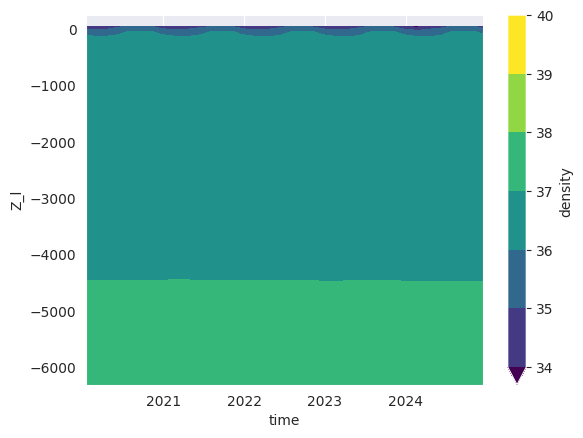

In [74]:
ds_SO.density.T.plot.contourf(vmin = 34, vmax = 40)

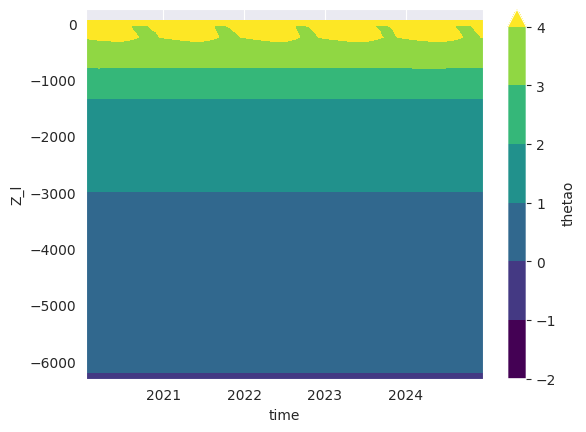

In [18]:
ds_SO.thetao.T.plot.contourf(vmin = -2, vmax = 4)

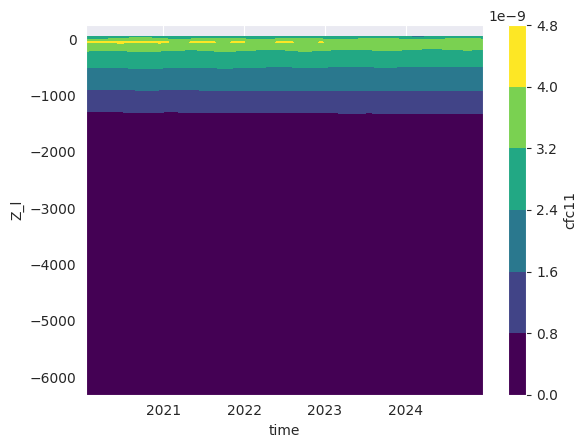

In [19]:
ds_SO.cfc11.T.plot.contourf()